# DATASCI W261: Machine Learning at Scale

### HW7 (Group Z)

- **Juanjo Carin, Christopher Llop, Sayantan Satpati**
- [juanjose.carin@ischool.berkeley.edu](mailto:juanjose.carin@ischol.berkeley.com)
- [christopher.llop@ischool.berkeley.edu](mailto:christopher.llop@ischool.berkeley.edu)
- [sayantan.satpati@ischool.berkeley.edu](mailto:sayantan.satpati@ischool.berkeley.edu)
- W261-2
- Week 09
- Submission date: 11/3/2015

# HW 9.0: Short answer questions

1. **What is PageRank and what is it used for in the context of web search?**

2. **What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to compute the steady state distibuton?**

3. **OPTIONAL: In topic-specific PageRank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)**

## Addendum questions from HW7

1. **Can we utilize combiners in the HW 7 to perform the shortest path implementation?**

2. **Does order inversion help with the HW 7 shortest path implementation?**



1. **PageRank** is an algorithm for computing a ranking for every web page based on the graph of the web. It uses (apart from the structure of that graph) the forward links and backlinks connecting the web pages, and has applications in search, browsing, traffic estimation, etc.

2. In order to compute the steady state distribution of the **Markov chain** that is the random surfer in which PageRank is based, the matrix that represents the random surfer must be stochastic. To have such a matrix, we must ensure that the random surfer does not get stuck at a dangling node, by adding a teleportation factor to all probabilities in the matrix ($\alpha/N$, where $N$ is the number of nodes in the web graph) such that the random surfer will jump to any node, with uniform probability. A second modification is that we have to distribute the probability mass ($m$) of all dangling nodes at a certain state to all the nodes in the graph; this is done by substituting all cells in a column of the transition matrix corresponding to a dangling node (i.e., a node with no forward links), which would be zero, by $1/N$.

3. By removing all columns of the transition matrix $M$ and all elements of the teleportation vector $p$ that correspond to nodes not reachable from nodes of a certain topic (i.e., nonzero nodes in $p$). In topic-specific PageRank, teleportation probabilities are not uniform: for a given topic, only nodes corresponding to that topic get a nonzero teleportation probability ($1/x$, with $x$ the number of nodes in that category), and the rest will have a zero teleportation probability.

-----------

## HW7 Addendum

1. **Yes**, we could use combiners. Say we have the following graph:

        A {B: 1, E: 10}
        B {C:1}
        C {D:1, F: 2}
        D {E:3}
        F {E: 1}
    
    In the 1st iteration the distance from A to E is set to 10. In the 4th iteration, the mapper emits both `(E, 6)` (A-B-C-D-E) and `(E, 5)` (A-B-C-F-E). A combiner would take both outputs from the mapper and discards the former, passing to the reducer only the latter, and hence reducing network traffic.
    
    This answer is based on the implementation of the shortest path for weighted links, the one that we used in HW7; if the graph is unweighted, a combiner would add no value.
    
    Another apporach would be 
    with a code quite similar to those in the reducers. I.e., they would update the SSSP and the Frontiers "*in advance*"(N.B.: this answer is based .
    
2. **No** (at least in the weighted graph version), since there is no general information about a node that must be used first.

# HW 9.1: MRJob implementation of basic PageRank

**Write a basic MRJob implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input (as explored in HW 7). Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1).**

**[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page, chooses the next page to which it will move by clicking at random, with probability d, one of the hyperlinks in the current page. This probability is represented by a so-called ‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer jumps to any web page in the network. If a page is a dangling end, meaning it has no outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform distribution and “teleports” to that page]**

**As you build your code, use the test data s3://ucb-mids-mls-networks/PageRank-test.txt with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck your work with the true result, displayed in the first image in the Wikipedia article: https://en.wikipedia.org/wiki/PageRank**

**and here for reference are the corresponding PageRank probabilities:**

    A,0.033
    B,0.384
    C,0.343
    D,0.039
    E,0.081
    F,0.039
    G,0.016
    H,0.016
    I,0.016
    J,0.016
    K,0.016

## Importing Libraries and Downloading Data

In [12]:
# Turn on autoreload for easier troubleshooting.
# This function causes iPython to re-load modules before executing code, which
    # is useful because we will be updating the MRJob code while troubleshooting
%load_ext autoreload
%autoreload 2

import networkx as nx
import ast
import matplotlib.pyplot as plt
%matplotlib notebook

GLOBAL_PATH = "/HD/Dropbox2/Dropbox/W261/HW9/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Get data from S3 for local exploration
!aws s3 cp s3://ucb-mids-mls-networks/PageRank-test.txt $GLOBAL_PATH

download: s3://ucb-mids-mls-networks/PageRank-test.txt to ../../../../../../../HD/Dropbox2/Dropbox/W261/HW9/PageRank-test.txt


## Graph representation

<IPython.core.display.Javascript object>


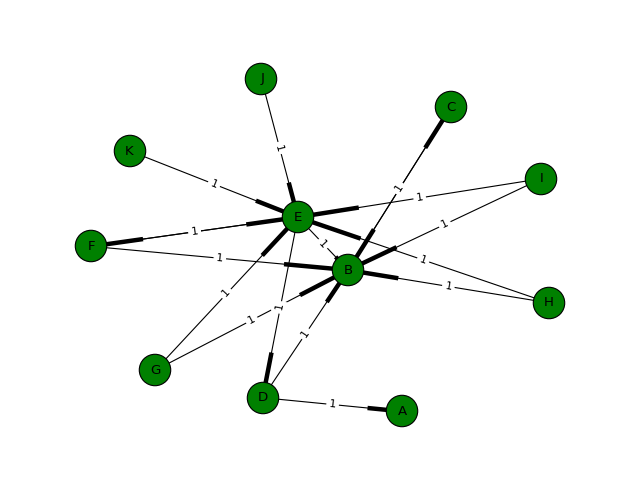

In [3]:
# Flexible Load Data Function
def load_data(filename):
    nodes = set()
    edges = set()
    with open (filename, 'r') as myfile:
        for line in myfile:
            line = line.split('\t')
            node = line[0]
            if node not in nodes:
                nodes.add(node)
            node_neighbors = ast.literal_eval(line[1])
            for k in node_neighbors.keys():
                edges.add((node, k, node_neighbors[k]))
                if k not in nodes:
                    nodes.add(k)
    return nodes, edges

# Plot Directed Graph
G=nx.DiGraph()
nodes, edges = load_data('./PageRank-test.txt')

# Load into networkx
for node in nodes:
    G.add_node(node)    
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

# Plot network 
pos=nx.spring_layout(G)
nx.draw(G,pos, with_labels = True, node_color='g', node_size = 800)
# Specifiy Edge Labels
edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
plt.title("Directed Toy Example with Weights")
plt.show()

## An implementation of PageRank in a Google Sheet :)

It probably does not scale too well :P ...but it helped understand all the steps required, and how dangling nodes and teleportation must be considered.

https://docs.google.com/spreadsheets/d/1PL5FW_BCQPf03CeT3_uz6gXHimfgeyK_be0Mi7tBMFE/edit?usp=sharing

## MRJob

In [13]:
%%writefile PageRank.py
#!/home/hduser/anaconda/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol
from mrjob.compat import get_jobconf_value
import ast
from math import log1p, exp, log

## A function to sum log probabilities
def sum_log(p, q):
    if q > p:
        b = log(q)
        if p == 0:
            return exp(b + log1p(0))
        else:
            a = log(p)
            return exp(b + log1p(exp(a-b)))
    else:
        if q == 0:
            if p == 0:
                return 0.
            else:
                a = log(p)
                return exp(a + log1p(0))
        else:
            b = log(q)
            a = log(p)
            return exp(a + log1p(exp(b-a)))
            
class PageRank(MRJob):
    
    #OUTPUT_PROTOCOL = RawValueProtocol

    alpha = 0.85

    def steps(self):
        return [
            MRStep(mapper_init = self.mapper1_init,
                   mapper = self.mapper1, 
                   mapper_final = self.mapper1_final, 
                   reducer_init = self.reducer1_init, 
                   reducer = self.reducer1, 
                   reducer_final = self.reducer1_final),
            MRStep(mapper_init = self.mapper2_init,
                   mapper = self.mapper2, 
                   mapper_final = self.mapper2_final, 
                   reducer = self.reducer2)
        ]

    def mapper1_init(self):
        ## Associative array for in-mapper combining
        self.nodes = {}
        self.nodes_prev = {}
        ## Keep track of nodes in the graph
        self.list_nodes = []
        self.list_sources = []
    
    def mapper1(self, _, line):
        ## Format of each line:
            ## n1 TAB {n2: 1, n3:1, ...} TAB PR(n1)
                ## The 3rd field is not present in the 1st iteration
                ## which only contains each node and its adjacency list
        #line = line.strip().split('\t')
        ## 1st field is a node that acts as source
            ## (Though from 2nd iteration on all nodes will be present,
            ## some with an empty list of outgoing links)
        #source = line[0]
        ## 2nd field is a dictionary of links with their weights
            ## (Set to 1 from 2nd iteration on; they're not relevant anyway)
        #sink = ast.literal_eval(line[1])
        ## Keep only the sinks, not the weights
        #sinks = sink.keys()
        ## Include those sinks in a list of nodes
        
        line = line.strip().split('\t')
        source = line[0].strip('"')
        if isinstance(ast.literal_eval(line[1]), dict):
            sinks = ast.literal_eval(line[1]).keys()
            if len(line) < 3:
                PR = 1e-3
                for sink in sinks:
                    self.nodes_prev[sink] = PR
            else:
                PR = float(line[2])
                self.nodes_prev[source] = PR
        else:
            sinks = ast.literal_eval(line[1])[0].keys()
            PR = float(ast.literal_eval(line[1])[1])
            self.nodes_prev[source] = PR

        for sink in sinks:
            if sink not in self.list_nodes:
                self.list_nodes.append(sink)

        ## Pass the graph structure (the adjacency list)
        yield source, [sinks]
        
        ## Include the source in the list of nodes, too
        if source not in self.list_nodes:
            self.list_nodes.append(source)
        # And also in a list of sources... if it really has outgoing links!
        if source not in self.list_sources and len(sinks) != 0:
            self.list_sources.append(source)
        ## If PR of the source is not present (1st iteration)
        #if len(line) < 3:
            ## All nodes have an initial PR of 1e-3
                ## The value can be any (not necessarily 1/|G|)
                    ## (We don't know the value of |G| yet!!!)
                ## Just takes more or less to converge
                    ## and the sum of PRs in the first iterations
                    ## will be less than 100%
        #    PR = 1e-3
            ## Keep track of the previous PR to distribute the PR mass
                ## of the dangling nodes
                ## (They are never sources, but have to be sinks)
        #    for sink in sinks:
        #        self.nodes_prev[sink] = PR    
        #else:
            ## From 2nd iteration on, we already know the PR
        #    PR = float(line[2])
        #    self.nodes_prev[source] = PR
        
        ## Distribute the mass of the source along its sinks
            ## We put the value in the associative array
            ## and emit it in the in-mapper combiner
        for node in sinks:
            self.nodes.setdefault(node,0.)
            self.nodes[node] = sum_log(self.nodes[node], PR/len(sinks))
    
    def mapper1_final(self):
        ## For all nodes detected
        for node in self.list_nodes:
            ## If they have ingoing links, emit their PR
                ## as well as the total number of nodes (|G|)
            if node in self.nodes.keys():
                yield node, [self.nodes[node], len(self.list_nodes), 0.]
            ## If not a source (i.e., a DANGLING NODE) emit its previos PR
                ## to be distributed; otherwise, 0
            if node in self.nodes_prev.keys():
                yield node, [0., len(self.list_nodes), self.nodes_prev[node]]
            ## If not (they are sources but not sinks), their PR will be 0
                ## (before considering dangling nodes & teleportation)
            else:
                yield node, [0., len(self.list_nodes), 0.]
                
        ## 1st mapper emits each node as key, and 3 values per node
            ## Current PR (w/o considering dangling nodes and teleportation yet)
            ## |G|: number of nodes in the graph
            ## Previous PR if node is a dangling one, 0 otherwise
        ## Also (part of) the structure of the graph (adjacency lists)
    
    def reducer1_init(self):
        ## Keep track of nodes in the graph
        self.nodes = {}
        self.dangling_nodes_mass = 0
        
    def reducer1(self, key, value):
        ## Variables to keep track / aggregate PRs, number of nodes, sinks, etc.
        PR = 0.
        num_nodes = 0
        sinks = {}
        outlinks = []
        
        if key not in self.nodes.keys():
            self.nodes.setdefault(key, [])
            
        prev_mass = 0.
        for v in value:
            node_type = 'sink'
            ## When the value is the graph structure (outlinks of a node)
            if isinstance(v[0], list):
                outlinks = v[0]
                if len(outlinks) != 0:
                    node_type = 'source'
            ## When the value is the mass passed by a neighbor linking to the 
                ## node (as well as the number of nodes and previous PR in 
                ## case of a dangling node)
            else:
                PR = sum_log(PR, v[0])
                # num_nodes = v[1]
                prev_mass = sum_log(prev_mass, v[2])
        if node_type == 'sink':
            self.dangling_nodes_mass = sum_log(self.dangling_nodes_mass, prev_mass)
        
        ## Add weights to the adjacency list to be consistent with the original
            ## file structure
        for node in outlinks:
            sinks[node] = 1
            
        ## The 1st job emits each node as key, and 4 values
            ## its adjacency list
            ## its current PageRank
            ## the total number of nodes found in the graph
            ## the previous PR in case of a dangling node
        self.nodes[key] = [sinks, PR, num_nodes]
        
    def reducer1_final(self):
        num_nodes = len(self.nodes.keys())
        for k, v in self.nodes.iteritems():
            yield k, [v[0], v[1], num_nodes, self.dangling_nodes_mass]            
    
    #############
    ## 2nd JOB ##
    #############
    
    def mapper2_init(self):
        ## Associative array for in-mapper combining
        self.nodes = {}
        ## Variable to keep track of the "lost" mass
        #self.dangling_nodes_mass = 0
        
    def mapper2(self, key, value):
        ## Aggregate (previous!) PR mass of the dangling nodes
        #self.dangling_nodes_mass = sum_log(self.dangling_nodes_mass, value[3])
        ## Don't need the 4th value anymore
        #self.nodes[key] = value[:3]
        yield key, value
    
    def mapper2_final(self):
        ## Emit the associative array
        for node in self.nodes.keys():
            value = self.nodes[node]
            ## Include the PR mass of dangling nodes again
                ## But now it's the total mass, and included in every node
            #value.append(self.dangling_nodes_mass)
            #yield node, value
        
    def reducer2(self, key, value):
        ## Emit only 2 values with each node
        for v in value:    
            ## 1) Its adjacency list
            sinks = v[0]
            ## 2) The corrected PR
                ## PR = alpha * PR + alpha * m / |G| + (1-alpha) * (1/|G|)
            PR = self.alpha*sum_log(v[1], v[3]/float(v[2]))
            PR = sum_log(PR, (1-self.alpha)/float(v[2]))
        yield key, [sinks, PR]
        
if __name__ == '__main__':
    PageRank.run()

Overwriting PageRank.py


In [14]:
!chmod a+x PageRank.py

In [15]:
!cp ./PageRank-test.txt ./PageRank-test2.txt
!python PageRank.py --jobconf mapred.reduce.tasks=4 --jobconf mapred.map.tasks=4 ./PageRank-test2.txt

using configs in /home/hduser/.mrjob.conf
creating tmp directory /tmp/PageRank.hduser.20151105.210600.888430
writing to /tmp/PageRank.hduser.20151105.210600.888430/step-0-mapper_part-00000
writing to /tmp/PageRank.hduser.20151105.210600.888430/step-0-mapper_part-00001
writing to /tmp/PageRank.hduser.20151105.210600.888430/step-0-mapper_part-00002
writing to /tmp/PageRank.hduser.20151105.210600.888430/step-0-mapper_part-00003
Counters from step 1:
  (no counters found)
writing to /tmp/PageRank.hduser.20151105.210600.888430/step-0-mapper-sorted
> sort /tmp/PageRank.hduser.20151105.210600.888430/step-0-mapper_part-00000 /tmp/PageRank.hduser.20151105.210600.888430/step-0-mapper_part-00001 /tmp/PageRank.hduser.20151105.210600.888430/step-0-mapper_part-00002 /tmp/PageRank.hduser.20151105.210600.888430/step-0-mapper_part-00003
writing to /tmp/PageRank.hduser.20151105.210600.888430/step-0-reducer_part-00000
writing to /tmp/PageRank.hduser.20151105.210600.888430/step-0-reducer_part-00001
writin

In [16]:
%%writefile PageRank.py
#!/home/hduser/anaconda/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol
from mrjob.compat import get_jobconf_value
import ast
from math import log1p, exp, log

GLOBAL_PATH = "/HD/Dropbox2/Dropbox/W261/HW9/"

## A function to sum log probabilities
def sum_log(p, q):
    if q > p:
        b = log(q)
        if p == 0:
            return exp(b + log1p(0))
        else:
            a = log(p)
            return exp(b + log1p(exp(a-b)))
    else:
        if q == 0:
            if p == 0:
                return 0.
            else:
                a = log(p)
                return exp(a + log1p(0))
        else:
            b = log(q)
            a = log(p)
            return exp(a + log1p(exp(b-a)))
            
class PageRank(MRJob):
    
    #OUTPUT_PROTOCOL = RawValueProtocol

    alpha = 0.85

    def steps(self):
        return [
            MRStep(mapper_init = self.mapper1_init,
                   mapper = self.mapper1, 
                   mapper_final = self.mapper1_final, 
                   reducer_init = self.reducer1_init, 
                   reducer = self.reducer1, 
                   reducer_final = self.reducer1_final),
            MRStep(mapper_init = self.mapper2_init,
                   mapper = self.mapper2, 
                   mapper_final = self.mapper2_final, 
                   reducer = self.reducer2)
        ]

    def mapper1_init(self):
        ## Associative array for in-mapper combining
        self.nodes = {}
        self.nodes_prev = {}
        ## Keep track of nodes in the graph
        self.list_nodes = []
        self.list_sources = []
    
    def mapper1(self, _, line):
        ## Format of each line:
            ## n1 TAB {n2: 1, n3:1, ...} TAB PR(n1)
                ## The 3rd field is not present in the 1st iteration
                ## which only contains each node and its adjacency list
        #line = line.strip().split('\t')
        ## 1st field is a node that acts as source
            ## (Though from 2nd iteration on all nodes will be present,
            ## some with an empty list of outgoing links)
        #source = line[0]
        ## 2nd field is a dictionary of links with their weights
            ## (Set to 1 from 2nd iteration on; they're not relevant anyway)
        #sink = ast.literal_eval(line[1])
        ## Keep only the sinks, not the weights
        #sinks = sink.keys()
        ## Include those sinks in a list of nodes
        
        line = line.strip().split('\t')
        source = line[0].strip('"')
        if isinstance(ast.literal_eval(line[1]), dict):
            sinks = ast.literal_eval(line[1]).keys()
            if len(line) < 3:
                PR = 1e-3
                for sink in sinks:
                    self.nodes_prev[sink] = PR
            else:
                PR = float(line[2])
                self.nodes_prev[source] = PR
        else:
            sinks = ast.literal_eval(line[1])[0].keys()
            PR = float(ast.literal_eval(line[1])[1])
            self.nodes_prev[source] = PR

        for sink in sinks:
            if sink not in self.list_nodes:
                self.list_nodes.append(sink)

        ## Pass the graph structure (the adjacency list)
        yield source, [sinks]
        
        ## Include the source in the list of nodes, too
        if source not in self.list_nodes:
            self.list_nodes.append(source)
        # And also in a list of sources... if it really has outgoing links!
        if source not in self.list_sources and len(sinks) != 0:
            self.list_sources.append(source)
        ## If PR of the source is not present (1st iteration)
        #if len(line) < 3:
            ## All nodes have an initial PR of 1e-3
                ## The value can be any (not necessarily 1/|G|)
                    ## (We don't know the value of |G| yet!!!)
                ## Just takes more or less to converge
                    ## and the sum of PRs in the first iterations
                    ## will be less than 100%
        #    PR = 1e-3
            ## Keep track of the previous PR to distribute the PR mass
                ## of the dangling nodes
                ## (They are never sources, but have to be sinks)
        #    for sink in sinks:
        #        self.nodes_prev[sink] = PR    
        #else:
            ## From 2nd iteration on, we already know the PR
        #    PR = float(line[2])
        #    self.nodes_prev[source] = PR
        
        ## Distribute the mass of the source along its sinks
            ## We put the value in the associative array
            ## and emit it in the in-mapper combiner
        for node in sinks:
            self.nodes.setdefault(node,0.)
            self.nodes[node] = sum_log(self.nodes[node], PR/len(sinks))
    
    def mapper1_final(self):
        ## For all nodes detected
        for node in self.list_nodes:
            ## If they have ingoing links, emit their PR
                ## as well as the total number of nodes (|G|)
            if node in self.nodes.keys():
                yield node, [self.nodes[node], len(self.list_nodes), 0.]
            ## If not a source (i.e., a DANGLING NODE) emit its previos PR
                ## to be distributed; otherwise, 0
            if node in self.nodes_prev.keys():
                yield node, [0., len(self.list_nodes), self.nodes_prev[node]]
            ## If not (they are sources but not sinks), their PR will be 0
                ## (before considering dangling nodes & teleportation)
            else:
                yield node, [0., len(self.list_nodes), 0.]
                
        ## 1st mapper emits each node as key, and 3 values per node
            ## Current PR (w/o considering dangling nodes and teleportation yet)
            ## |G|: number of nodes in the graph
            ## Previous PR if node is a dangling one, 0 otherwise
        ## Also (part of) the structure of the graph (adjacency lists)
    
    def reducer1_init(self):
        ## Keep track of nodes in the graph
        self.nodes = {}
        self.dangling_nodes_mass = 0
        
    def reducer1(self, key, value):
        ## Variables to keep track / aggregate PRs, number of nodes, sinks, etc.
        PR = 0.
        num_nodes = 0
        sinks = {}
        outlinks = []
        
        if key not in self.nodes.keys():
            self.nodes.setdefault(key, [])
            
        prev_mass = 0.
        for v in value:
            node_type = 'sink'
            ## When the value is the graph structure (outlinks of a node)
            if isinstance(v[0], list):
                outlinks = v[0]
                if len(outlinks) != 0:
                    node_type = 'source'
            ## When the value is the mass passed by a neighbor linking to the 
                ## node (as well as the number of nodes and previous PR in 
                ## case of a dangling node)
            else:
                PR = sum_log(PR, v[0])
                # num_nodes = v[1]
                prev_mass = sum_log(prev_mass, v[2])
        if node_type == 'sink':
            self.dangling_nodes_mass = sum_log(self.dangling_nodes_mass, prev_mass)
        
        ## Add weights to the adjacency list to be consistent with the original
            ## file structure
        for node in outlinks:
            sinks[node] = 1
            
        ## The 1st job emits each node as key, and 4 values
            ## its adjacency list
            ## its current PageRank
            ## the total number of nodes found in the graph
            ## the previous PR in case of a dangling node
        self.nodes[key] = [sinks, PR, num_nodes]
        
    def reducer1_final(self):
        num_nodes = len(self.nodes.keys())
        with open(GLOBAL_PATH + 'num_mass.txt', 'a') as f:
                f.writelines(str(num_nodes) + '\t' + str(self.dangling_nodes_mass) + '\n')
        for k, v in self.nodes.iteritems():
            yield k, [v[0], v[1]]
            
    
    #############
    ## 2nd JOB ##
    #############
    
    def mapper2_init(self):
        ## Associative array for in-mapper combining
        self.nodes = {}
        ## Variable to keep track of the "lost" mass
        #self.dangling_nodes_mass = 0
        
    def mapper2(self, key, value):
        ## Aggregate (previous!) PR mass of the dangling nodes
        #self.dangling_nodes_mass = sum_log(self.dangling_nodes_mass, value[3])
        ## Don't need the 4th value anymore
        #self.nodes[key] = value[:3]
        yield key, value
    
    def mapper2_final(self):
        ## Emit the associative array
        for node in self.nodes.keys():
            value = self.nodes[node]
            ## Include the PR mass of dangling nodes again
                ## But now it's the total mass, and included in every node
            #value.append(self.dangling_nodes_mass)
            #yield node, value
        
    def reducer2(self, key, value):
        mass = 0.
        num_nodes = 0
        with open(GLOBAL_PATH + 'num_mass.txt', 'r') as f:
            for line in f:
                line = line.strip().split('\t')
                num_nodes = num_nodes + int(line[0])
                mass = mass + float(line[1])
        for v in value:    
            ## 1) Its adjacency list
            sinks = v[0]
            ## 2) The corrected PR
                ## PR = alpha * PR + alpha * m / |G| + (1-alpha) * (1/|G|)
            PR = self.alpha*sum_log(v[1], mass/num_nodes)
            PR = sum_log(PR, (1-self.alpha)/num_nodes)
        yield key, [sinks, PR]
        
if __name__ == '__main__':
    PageRank.run()

Overwriting PageRank.py


In [17]:
!chmod a+x PageRank.py

In [18]:
!cp ./PageRank-test.txt ./PageRank-test2.txt
!python PageRank.py --jobconf mapred.reduce.tasks=4 --jobconf mapred.map.tasks=4 ./PageRank-test2.txt

using configs in /home/hduser/.mrjob.conf
creating tmp directory /tmp/PageRank.hduser.20151105.210612.713003
writing to /tmp/PageRank.hduser.20151105.210612.713003/step-0-mapper_part-00000
writing to /tmp/PageRank.hduser.20151105.210612.713003/step-0-mapper_part-00001
writing to /tmp/PageRank.hduser.20151105.210612.713003/step-0-mapper_part-00002
writing to /tmp/PageRank.hduser.20151105.210612.713003/step-0-mapper_part-00003
Counters from step 1:
  (no counters found)
writing to /tmp/PageRank.hduser.20151105.210612.713003/step-0-mapper-sorted
> sort /tmp/PageRank.hduser.20151105.210612.713003/step-0-mapper_part-00000 /tmp/PageRank.hduser.20151105.210612.713003/step-0-mapper_part-00001 /tmp/PageRank.hduser.20151105.210612.713003/step-0-mapper_part-00002 /tmp/PageRank.hduser.20151105.210612.713003/step-0-mapper_part-00003
writing to /tmp/PageRank.hduser.20151105.210612.713003/step-0-reducer_part-00000
writing to /tmp/PageRank.hduser.20151105.210612.713003/step-0-reducer_part-00001
writin

## Driver

In [19]:
TEMP_FILE = "/HD/Dropbox2/Dropbox/W261/HW9/num_mass.txt"
!rm $TEMP_FILE

from PageRank import PageRank

!cp ./PageRank-test.txt ./PageRank-test2.txt
mr_job = PageRank(args=[GLOBAL_PATH + 'PageRank-test2.txt', '--jobconf', 
                        'mapred.map.tasks=10', '--jobconf', 
                        'mapred.reduce.tasks=4'])

i = 1
num_nodes = 0
sum_partial_diff_PR = float('inf')

## Iterate until the sum of partial differences between current 
    ## and previous PR is less than 0.5%
while sum_partial_diff_PR > .0001:
    if i != 1:
        PR_prev = PR
    if i % 10 == 0 or i == 1:
        print "\nIteration " + str(i) + ":"
    PR = []
    with mr_job.make_runner() as runner: 
        runner.run()
        with open(GLOBAL_PATH + 'PageRank-test2.txt', 'w') as f:
            for line in runner.stream_output():
                key,value =  mr_job.parse_output_line(line)
                if i == 1:
                    num_nodes += 1
                if i % 10 == 0 or i == 1:
                    print key + '\t' + str(value[1])
                PR.append(value[1])
                f.writelines(key + '\t' + '\t'.join([str(x) for x in value]) + '\n')
            if i == 1:
                PR_prev = [float('inf')]*num_nodes
            sum_partial_diff_PR = sum([abs(x-y) for x,y in zip(PR, PR_prev)])
    !rm $TEMP_FILE
    i = i + 1

print "\nLAST ITERATION (" + str(i) + "):"
f = open(GLOBAL_PATH + 'PageRank-test2.txt', 'r')
for line in f.readlines():
    line = line.strip().split('\t')
    ## Put PR before adjacency list
    print line[0] + '\t' + str(round(float(line[2]), 3)) + '\t' + line[1]


Iteration 1:
F	0.013996969697
G	0.0137136363636
H	0.0137136363636
I	0.0137136363636
J	0.0137136363636
K	0.0137136363636
A	0.0141386363636
B	0.016971969697
C	0.0145636363636
D	0.013996969697
E	0.0171136363636

Iteration 10:
F	0.0389757505673
G	0.0161549980096
H	0.0161549980096
I	0.0161549980096
J	0.0161549980096
K	0.0161549980096
A	0.0326915594709
B	0.288840049719
C	0.244307631704
D	0.0389757505673
E	0.0807254820292

Iteration 20:
F	0.0390868732932
G	0.0161694501703
H	0.0161694501703
I	0.0161694501703
J	0.0161694501703
K	0.0161694501703
A	0.0327813002552
B	0.365546305584
C	0.323432872186
D	0.0390868732932
E	0.0808853482945

Iteration 30:
F	0.0390870916561
G	0.0161694789583
H	0.0161694789583
I	0.0161694789583
J	0.0161694789583
K	0.0161694789583
A	0.0327814927566
B	0.380688866159
C	0.339075549229
D	0.0390870916561
E	0.0808856925133

Iteration 40:
F	0.039087092099
G	0.0161694790167
H	0.0161694790167
I	0.0161694790167
J	0.0161694790167
K	0.0161694790167
A	0.0327814931585
B	0.383670134575
C

    A,0.033
    B,0.384
    C,0.343
    D,0.039
    E,0.081
    F,0.039
    G,0.016
    H,0.016
    I,0.016
    J,0.016
    K,0.016

In [20]:
!aws s3 cp s3://ucb-mids-mls-networks/PageRank-test.txt s3://ucb-mids-mls-juanjocarin/PageRank-test2.txt 

copy: s3://ucb-mids-mls-networks/PageRank-test.txt to s3://ucb-mids-mls-juanjocarin/PageRank-test2.txt


In [2]:
%%writefile PageRank_AWS.py
#!/home/hduser/anaconda/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol
from mrjob.compat import get_jobconf_value
import ast
from math import log1p, exp, log
import boto
from boto.s3.key import Key

from boto.s3.connection import S3Connection


## A function to sum log probabilities
def sum_log(p, q):
    if q > p:
        b = log(q)
        if p == 0:
            return exp(b + log1p(0))
        else:
            a = log(p)
            return exp(b + log1p(exp(a-b)))
    else:
        if q == 0:
            if p == 0:
                return 0.
            else:
                a = log(p)
                return exp(a + log1p(0))
        else:
            b = log(q)
            a = log(p)
            return exp(a + log1p(exp(b-a)))
            
class PageRank_AWS(MRJob):
    
    iteration = get_jobconf_value('iteration')
    
    #OUTPUT_PROTOCOL = RawValueProtocol

    alpha = 0.85

    def steps(self):
        return [
            MRStep(mapper_init = self.mapper1_init,
                   mapper = self.mapper1, 
                   mapper_final = self.mapper1_final, 
                   reducer_init = self.reducer1_init, 
                   reducer = self.reducer1, 
                   reducer_final = self.reducer1_final),
            MRStep(mapper = self.mapper2, 
                   reducer = self.reducer2)
        ]

    def mapper1_init(self):
        ## Associative array for in-mapper combining
        self.nodes = {}
        self.nodes_prev = {}
        ## Keep track of nodes in the graph
        self.list_nodes = []
        self.list_sources = []
    
    def mapper1(self, _, line):
        ## Format of each line:
            ## n1 TAB {n2: 1, n3:1, ...} TAB PR(n1)
                ## The 3rd field is not present in the 1st iteration
                ## which only contains each node and its adjacency list
        #line = line.strip().split('\t')
        ## 1st field is a node that acts as source
            ## (Though from 2nd iteration on all nodes will be present,
            ## some with an empty list of outgoing links)
        #source = line[0]
        ## 2nd field is a dictionary of links with their weights
            ## (Set to 1 from 2nd iteration on; they're not relevant anyway)
        #sink = ast.literal_eval(line[1])
        ## Keep only the sinks, not the weights
        #sinks = sink.keys()
        ## Include those sinks in a list of nodes
        
        line = line.strip().split('\t')
        source = line[0].strip('"')
        if isinstance(ast.literal_eval(line[1]), dict):
            sinks = ast.literal_eval(line[1]).keys()
            if len(line) < 3:
                PR = 1e-3
                for sink in sinks:
                    self.nodes_prev[sink] = PR
            else:
                PR = float(line[2])
                self.nodes_prev[source] = PR
        else:
            sinks = ast.literal_eval(line[1])[0].keys()
            PR = float(ast.literal_eval(line[1])[1])
            self.nodes_prev[source] = PR

        for sink in sinks:
            if sink not in self.list_nodes:
                self.list_nodes.append(sink)

        ## Pass the graph structure (the adjacency list)
        yield source, [sinks]
        
        ## Include the source in the list of nodes, too
        if source not in self.list_nodes:
            self.list_nodes.append(source)
        # And also in a list of sources... if it really has outgoing links!
        if source not in self.list_sources and len(sinks) != 0:
            self.list_sources.append(source)
        ## If PR of the source is not present (1st iteration)
        #if len(line) < 3:
            ## All nodes have an initial PR of 1e-3
                ## The value can be any (not necessarily 1/|G|)
                    ## (We don't know the value of |G| yet!!!)
                ## Just takes more or less to converge
                    ## and the sum of PRs in the first iterations
                    ## will be less than 100%
        #    PR = 1e-3
            ## Keep track of the previous PR to distribute the PR mass
                ## of the dangling nodes
                ## (They are never sources, but have to be sinks)
        #    for sink in sinks:
        #        self.nodes_prev[sink] = PR    
        #else:
            ## From 2nd iteration on, we already know the PR
        #    PR = float(line[2])
        #    self.nodes_prev[source] = PR
        
        ## Distribute the mass of the source along its sinks
            ## We put the value in the associative array
            ## and emit it in the in-mapper combiner
        for node in sinks:
            self.nodes.setdefault(node,0.)
            self.nodes[node] = self.nodes[node] + PR/len(sinks)
    
    def mapper1_final(self):
        ## For all nodes detected
        for node in self.list_nodes:
            ## If they have ingoing links, emit their PR
                ## as well as the total number of nodes (|G|)
            if node in self.nodes.keys():
                yield node, [self.nodes[node], len(self.list_nodes), 0.]
            ## If not a source (i.e., a DANGLING NODE) emit its previos PR
                ## to be distributed; otherwise, 0
            if node in self.nodes_prev.keys():
                yield node, [0., len(self.list_nodes), self.nodes_prev[node]]
            ## If not (they are sources but not sinks), their PR will be 0
                ## (before considering dangling nodes & teleportation)
            else:
                yield node, [0., len(self.list_nodes), 0.]
                
        ## 1st mapper emits each node as key, and 3 values per node
            ## Current PR (w/o considering dangling nodes and teleportation yet)
            ## |G|: number of nodes in the graph
            ## Previous PR if node is a dangling one, 0 otherwise
        ## Also (part of) the structure of the graph (adjacency lists)
    
    def reducer1_init(self):
        ## Keep track of nodes in the graph
        self.nodes = {}
        self.dangling_nodes_mass = 0
        
    def reducer1(self, key, value):
        ## Variables to keep track / aggregate PRs, number of nodes, sinks, etc.
        PR = 0.
        num_nodes = 0
        sinks = {}
        outlinks = []
        
        if key not in self.nodes.keys():
            self.nodes.setdefault(key, [])
            
        prev_mass = 0.
        for v in value:
            node_type = 'sink'
            ## When the value is the graph structure (outlinks of a node)
            if isinstance(v[0], list):
                outlinks = v[0]
                if len(outlinks) != 0:
                    node_type = 'source'
            ## When the value is the mass passed by a neighbor linking to the 
                ## node (as well as the number of nodes and previous PR in 
                ## case of a dangling node)
            else:
                PR = PR + v[0]
                # num_nodes = v[1]
                prev_mass = prev_mass + v[2]
        if node_type == 'sink':
            self.dangling_nodes_mass = self.dangling_nodes_mass + prev_mass
        
        ## Add weights to the adjacency list to be consistent with the original
            ## file structure
        for node in outlinks:
            sinks[node] = 1
            
        ## The 1st job emits each node as key, and 4 values
            ## its adjacency list
            ## its current PageRank
            ## the total number of nodes found in the graph
            ## the previous PR in case of a dangling node
        self.nodes[key] = [sinks, PR, num_nodes]
        
    def reducer1_final(self):
        num_nodes = len(self.nodes.keys())
        #conn = boto.connect_s3()
        
        aws_access_key_id = get_jobconf_value('aws_access_key_id')
        aws_secret_access_key = get_jobconf_value('aws_secret_access_key')
        conn = S3Connection(aws_access_key_id,aws_secret_access_key)
        mybucket = conn.get_bucket('ucb-mids-mls-juanjocarin')
        k = Key(mybucket)
        mykey = 'num_mass{}'.format(self.iteration)
        k.key = mykey        
        k.set_contents_from_strget_jobconf_valueing(str(num_nodes) + '\t' + str(self.dangling_nodes_mass))
        for k, v in self.nodes.iteritems():
            yield k, [v[0], v[1]]
                
    #############
    ## 2nd JOB ##
    #############
    
    def mapper2_init(self):
        ## Associative array for in-mapper combining
        self.nodes = {}
        ## Variable to keep track of the "lost" mass
        #self.dangling_nodes_mass = 0
        
    def mapper2(self, key, value):
        ## Aggregate (previous!) PR mass of the dangling nodes
        #self.dangling_nodes_mass = sum_log(self.dangling_nodes_mass, value[3])
        ## Don't need the 4th value anymore
        #self.nodes[key] = value[:3]
        yield key, value
    
    def mapper2_final(self):
        ## Emit the associative array
        for node in self.nodes.keys():
            value = self.nodes[node]
            ## Include the PR mass of dangling nodes again
                ## But now it's the total mass, and included in every node
            #value.append(self.dangling_nodes_mass)
            #yield node, value
        
    def reducer2(self, key, value):
        mass = 0.
        num_nodes = 0
        
        #conn = boto.connect_s3()
        aws_access_key_id = get_jobconf_value('aws_access_key_id')
        aws_secret_access_key = get_jobconf_value('aws_secret_access_key')
        conn = S3Connection(aws_access_key_id,aws_secret_access_key)


        mybucket = conn.get_bucket('ucb-mids-mls-juanjocarin')
        k = Key(mybucket)
        mykey = 'num_mass{}'.format(self.iteration)
        k.key = mykey
        data = k.get_contents_as_string()        
        data = data.strip().split('\t')
        num_nodes = num_nodes + int(data[0])
        mass = mass + float(data[1])
        for v in value:    
            ## 1) Its adjacency list
            sinks = v[0]
            ## 2) The corrected PR
                ## PR = alpha * PR + alpha * m / |G| + (1-alpha) * (1/|G|)
            PR = self.alpha*(v[1] + mass/num_nodes)
            PR = PR + (1-self.alpha)/num_nodes
        yield key, [sinks, PR]
        
if __name__ == '__main__':
    PageRank_AWS.run()

Overwriting PageRank_AWS.py


In [3]:
!chmod a+x PageRank_AWS.py

In [8]:
from PageRank_AWS import PageRank_AWS
import boto
from boto.s3.key import Key
from boto.s3.connection import S3Connection

GLOBAL_DATA = 's3://ucb-mids-mls-juanjocarin/PageRank-test2.txt'

aws_creds = {}
with open("/home/hduser/.aws/credentials", "r") as f:
    for l in f:
        if l.startswith('aws'):
            t = l.split('=')
            aws_creds[t[0].strip()] = t[1].strip()

i = 1
num_nodes = 0
sum_partial_diff_PR = float('inf')

while i <= 10:
    print "Iteration: " + str(i) + ":"
    out_dir = 's3://ucb-mids-mls-juanjocarin/hw9/{0}'.format(i)
    if i == 1:
        mr_job = PageRank_AWS(args=[GLOBAL_DATA, '-r', 'emr', 
                                '--output-dir', out_dir,
                                '--pool-emr-job-flows', '--max-hours-idle=1', 
                                '--jobconf', 'mapred.reduce.tasks=1',
                                '--jobconf', 'aws_access_key_id={0}'.format(aws_creds['aws_access_key_id']),
                                '--jobconf', 'aws_secret_access_key={0}'.format(aws_creds['aws_secret_access_key']),
                                '--jobconf', 'iteration={0}'.format(i)])

    else:
        mr_job = PageRank_AWS(args=['-r', 'emr', 's3://ucb-mids-mls-juanjocarin/hw9/{0}/'.format(i-1),
                                    '--output-dir', out_dir,
                                    '--pool-emr-job-flows', '--max-hours-idle=1', 
                                    '--jobconf', 'aws_access_key_id={0}'.format(aws_creds['aws_access_key_id']),
                                    '--jobconf', 'aws_secret_access_key={0}'.format(aws_creds['aws_secret_access_key']),
                                    '--jobconf', 'mapred.reduce.tasks=1', 
                                    '--jobconf', 'iteration={0}'.format(i)])
    with mr_job.make_runner() as runner: 
        runner.run()
        for line in runner.stream_output():
            print line
    i = i+1

ERROR:mrjob.emr:Job on job flow j-3PEKXOKDN0F4B failed with status WAITING: Waiting after step failed


Iteration: 1:


Exception: Operation requires job flow to terminate, but it may never do so.

In [ ]:
from PageRank import PageRank

GLOBAL_DATA = 's3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt'

mr_job = PageRank(args=[GLOBAL_DATA, '-r', 'emr', 'mapred.reduce.tasks=1', 
                        '--pool-emr-job-flows', '--max-hours-idle=1', 
                        '--jobconf', 'mapred.reduce.tasks=1'])
#                        '--bootstrap-action=s3://elasticmapreduce/bootstrap-actions/configure-hadoop \
#                        -m mapred.tasktracker.reduce.tasks.maximum=1'])

i = 1
num_nodes = 0
sum_partial_diff_PR = float('inf')

while i < 5:
    print "Iteration: " + str(i) + ":"
    out_dir = 's3://ucb-mids-mls-juanjocarin/hw9/{0}'.format(i)
    if i == 1:
        mr_job = PageRank(args=[GLOBAL_DATA, '-r', 'emr', 
                                '--output-dir', out_dir,
                                '--pool-emr-job-flows', '--max-hours-idle=1', 
                                '--jobconf', 'mapred.reduce.tasks=1'])

    else:
        mr_job = PageRank(args=['-r', 'emr', 's3://ucb-mids-mls-juanjocarin/hw9/{0}/'.format(i-1),
                                '--output-dir', out_dir,
                                '--pool-emr-job-flows', '--max-hours-idle=1', 
                                '--jobconf', 'mapred.reduce.tasks=1'])
    with mr_job.make_runner() as runner: 
        runner.run()
        if i == 4:
            j =0
            for line in runner.stream_output():
                if j<10:
                    print line
                    j+=1
    i = i+1

Iteration: 1:
Traceback (most recent call last):
  File "/home/hduser/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/hduser/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
  File "/home/hduser/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 285, in _fixed_getinnerframes
    lines = ulinecache.getlines(file)[start:end]
  File "/home/hduser/anaconda/lib/python2.7/site-packages/IPython/utils/ulinecache.py", line 37, in getlines
    return [l.decode(encoding, 'replace') for l in lines]
  File "/home/hduser/anaconda/lib/python2.7/encodings/utf_8.py", line 15, in decode
    def decode(input, errors='strict'):
KeyboardInterrupt


ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



TypeError: 'NoneType' object is not iterable

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/home/hduser/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 407, in _run_callback
    callback(*args, **kwargs)
  File "/home/hduser/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hduser/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py", line 252, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/hduser/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py", line 213, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/hduser/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py", line 388, in execute_request
    self._abort_queues()
  File "/home/hduser/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py", line 588, in _abort_queues
    self._abort_queue(stream)
  Fil

In [26]:
from PageRank import PageRank
import boto
from boto.s3.key import Key

GLOBAL_DATA = 's3://ucb-mids-mls-juanjocarin/PageRank-test2.txt'

mr_job = PageRank(args=[GLOBAL_DATA, '-r', 'emr', 
                                  '--pool-emr-job-flows', '--max-hours-idle=1'])


i = 1
num_nodes = 0
sum_partial_diff_PR = float('inf')

## Iterate until the sum of partial differences between current 
    ## and previous PR is less than 0.5%
#while sum_partial_diff_PR > .0005:
while i < 2:
    if i != 1:
        PR_prev = PR
    if i % 10 == 0 or i == 1:
        print "\nIteration " + str(i) + ":"
    PR = []
    with mr_job.make_runner() as runner: 
        runner.run()
        node_text = ''
        for line in runner.stream_output():
            print line
    i += 1

KeyboardInterrupt: 

In [ ]:
            key,value =  mr_job.parse_output_line(line)
            if i == 1:
                num_nodes += 1
            if i % 10 == 0 or i == 1:
                print key + '\t' + str(value[1])
            PR.append(value[1])
            node_text = node_text + key + '\t' + '\t'.join([str(x) for x in value]) + '\n'
            if i == 1:
                PR_prev = [float('inf')]*num_nodes
            sum_partial_diff_PR = sum([abs(x-y) for x,y in zip(PR, PR_prev)])
        conn = boto.connect_s3()
        mybucket = conn.get_bucket('ucb-mids-mls-juanjocarin')
        k = Key(mybucket)
        mykey = 'PageRank-test2.txt'
        k.key = mykey
        k.set_contents_from_string(node_text)
    i = i + 1

!aws s3 cp s3://ucb-mids-mls-networks/PageRank-test2.txt $GLOBAL_PATH

print "\nLAST ITERATION (" + str(i) + "):"
f = open(GLOBAL_PATH + 'PageRank-test2.txt', 'r')
for line in f.readlines():
    line = line.strip().split('\t')
    ## Put PR before adjacency list
    print line[0] + '\t' + str(round(float(line[2]),3)) + '\t' + line[1]

# HW 9.2: Exploring PageRank teleportation and network plots

In [31]:
%%writefile mrjob_preproc_hw91.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol
from mrjob.compat import get_jobconf_value
import sys
import ast


class FilePreProc(MRJob):
        
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                  reducer=self.reducer)
        ]
    

    def mapper(self, _, line):
        t = line.strip().split('\t')
        adj_list = ast.literal_eval(t[1])
        
        yield t[0], adj_list
        
        for n in adj_list:
            yield n, '*'
          
    def reducer(self, key, values):  
        source = False
        adj_list = {}
        for v in values:
            if isinstance(v, dict):
                source = True
                adj_list = v
        yield key, adj_list

if __name__ == '__main__':
    FilePreProc.run()

Writing mrjob_preproc_hw91.py


In [32]:
!chmod a+x mrjob_preproc_hw91.py

In [53]:
from mrjob_preproc_hw91 import FilePreProc
import ast

GLOBAL_DATA = 's3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt'

mr_job = FilePreProc(args=[GLOBAL_DATA, '-r', 'emr', 
                           '--pool-emr-job-flows', '--max-hours-idle=1'])

with mr_job.make_runner() as runner: 
    runner.run()
    with open(GLOBAL_PATH + 'all-pages-indexed-out-complete.txt', 'w') as f:
        for line in runner.stream_output():
            key, value =  mr_job.parse_output_line(line)
            f.writelines(str(int(key)) + '\t' + str(value) + '\n')

In [55]:
!wc -l all-pages-indexed-out-complete.txt

15192277 all-pages-indexed-out-complete.txt


In [56]:
!aws s3 cp all-pages-indexed-out-complete.txt s3://ucb-mids-mls-juanjocarin/all-pages-indexed-out-complete.txt

upload: ./all-pages-indexed-out-complete.txt to s3://ucb-mids-mls-juanjocarin/all-pages-indexed-out-complete.txt


In [21]:
%%writefile mrjob_hw93.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol
from mrjob.compat import get_jobconf_value
import sys
import ast
from numpy import log1p, exp, log
from boto.s3.connection import S3Connection
from boto.s3.key import Key
import boto

class PageRank_AWS(MRJob):
    
    INPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                  reducer=self.reducer),
            MRStep(mapper_init=self.mapper_dangling_init,
                mapper=self.mapper_dangling)
        ]
    

    def mapper(self, key, value):
        nodes = int(get_jobconf_value('nodes'))
        i = int(get_jobconf_value('iteration'))
        #sys.stderr.write('[M] {0}, {1} \n'.format(key, value))
        key = key.replace("\"","")
        key = key.replace("\\","")
        adj_list = ast.literal_eval(value)
      
        score = 0
        l = 0
        
        if 'score' in adj_list.keys():
            # Previous Mass/Page Rank
            score = adj_list['score']
            l = len(adj_list) - 1
        else: # First iteration ('score' not yet part of the adjacency list!)
            # Start with uniform probability distribution
            score = 1.0 / nodes
            l = len(adj_list)
            adj_list['score'] = score
            
        if l == 0: # Only 'score' & no out links [Dangling!]
            sys.stderr.write('[{0}][M] "DANGLING MASS" | {1} | {2}\n'.format(i, key, score))
            # Emit using a special key; Accumlate in Reducer;Distribute in the next MRJob
            yield 'DANGLING', ('SCORE', score)
       
        # Emit the Graph Structure
        yield key, ('GRAPH', adj_list)
                    
        # Emit the new Mass/Page Rank
        for n in adj_list:
            if n != 'score':
                yield n, ('SCORE', score/l)
                               
    def combiner(self, key, values):
        pass

        
    def reducer(self, key, values):     
        i = int(get_jobconf_value('iteration'))
        teleportation = float(get_jobconf_value('teleportation'))
        nodes = int(get_jobconf_value('nodes'))
        aws_access_key_id = get_jobconf_value('aws_access_key_id')
        aws_secret_access_key = get_jobconf_value('aws_secret_access_key')
        
        adj_list = None
        total_score = 0

        for value_type, value in values:
            if value_type == 'GRAPH':
                adj_list = value
            else:
                assert value_type == 'SCORE'
                total_score += value
                #total_score = sum_log(total_score, value)
                
        # Write Special Key to S3
        if key == 'DANGLING':
            # Write accumulated Dangling Score in a S3 Key
            try:
                conn = boto.connect_s3()
                bucket = conn.get_bucket('ucb-mids-mls-juanjocarin')
                k = Key(bucket)
                k.key = 'hw93/dangling_mass/{0}'.format(i) # Same as iteration
                k.set_contents_from_string(str(total_score))
            except boto.exception.S3ResponseError as err:
                sys.stderr.write(err)
                sys.exit(1)
        else:
            #total_score = (teleportation / nodes) + ((1 - teleportation) * total_score)
            #total_score = sum_log((teleportation / nodes), ((1 - teleportation) * total_score))
            if adj_list:
                adj_list['score'] = total_score
            else:
                adj_list = {'score': total_score}
    
            #sys.stderr.write('[R2] {0} | {1} | {2}\n\n'.format(key, total_score, adj_list))
            yield key, adj_list
       

    def mapper_dangling_init(self):
        i = int(get_jobconf_value('iteration'))
        aws_access_key_id = get_jobconf_value('aws_access_key_id')
        aws_secret_access_key = get_jobconf_value('aws_secret_access_key')
        
        self.dangling_mass = 0
        
        # Read Dangling Mass from S3 Bucket
        try:
            conn = boto.connect_s3()
            bucket = conn.get_bucket('ucb-mids-mls-juanjocarin')
            k = Key(bucket)
            k.key = 'hw93/dangling_mass/{0}'.format(i) # Same as iteration
            self.dangling_mass = float(k.get_contents_as_string())
        except boto.exception.S3ResponseError as err:
            sys.stderr.write(err)
            sys.exit(1)
        
        sys.stderr.write('[{0}][M_D] DANGLING MASS: {1}\n'.format(i, self.dangling_mass))
        
    def mapper_dangling(self, key, value):
        #sys.stderr.write('[M_D] {0}, {1} \n'.format(key, value))
        i = int(get_jobconf_value('iteration'))
        key = key.replace("\"","")
        key = key.replace("\\","")
        adj_list = ast.literal_eval(str(value))
        
        if self.dangling_mass > 0:
            nodes = int(get_jobconf_value('nodes'))
            teleportation = float(get_jobconf_value('teleportation'))
            score = adj_list['score']
            modified_score = (teleportation / nodes) + (1 - teleportation) * ((self.dangling_mass / nodes) + score)
            #modified_score = sum_log((teleportation / nodes), (1 - teleportation)*(self.dangling_mass / nodes))
            #modified_score = sum_log(modified_score, (1 - teleportation)*score)
            adj_list['score'] = modified_score
            
        yield key, adj_list
        
if __name__ == '__main__':
    PageRank_AWS.run()

Overwriting mrjob_hw93.py


In [22]:
!chmod a+x mrjob_hw93.py

In [1]:
%reload_ext autoreload
%autoreload 2
from mrjob_hw93 import PageRank_AWS
import ast
import sys
import pprint


cnt = 0
MAX_ITERATIONS = 10
NODES = 15192277
TELEPORTATION = 0.15

# Delete Existing Output
!aws s3 rm --recursive s3://ucb-mids-mls-juanjocarin/hw93/output/

    
aws_creds = {}
with open("/home/hduser/.aws/credentials", "r") as f:
    for l in f:
        if l.startswith('aws'):
            t = l.split('=')
            aws_creds[t[0].strip()] = t[1].strip()

# After so many iterations (TBD: Convergence Criteria)
while cnt < MAX_ITERATIONS:
    print "\n\n Start Iteration: " + str(cnt+1) + ":"
    
    out_dir = 's3://ucb-mids-mls-juanjocarin/hw93/output/{0}'.format(cnt)
    print 'Output Dir: {0}'.format(out_dir)
    
    if cnt == 0:
        mr_job = PageRank_AWS(args=['s3://ucb-mids-mls-juanjocarin/all-pages-indexed-out-complete.txt',
                                    '-r', 'emr', '--output-dir', out_dir,
                                    '--jobconf', 'teleportation={0}'.format(TELEPORTATION),
                                    '--jobconf', 'nodes={0}'.format(NODES),
                                    '--jobconf', 'iteration={0}'.format(cnt+1),
                                    '--jobconf', 'aws_access_key_id={0}'.format(aws_creds['aws_access_key_id']),
                                    '--jobconf', 'aws_secret_access_key={0}'.format(aws_creds['aws_secret_access_key']),
                                    '--pool-emr-job-flows', 
                                    '--max-hours-idle', '1'])
    else:
        mr_job = PageRank_AWS(args=['s3://ucb-mids-mls-juanjocarin/hw93/output/{0}/'.format(cnt-1),
                                    '-r', 'emr', '--output-dir', out_dir,
                                    '--jobconf', 'teleportation={0}'.format(TELEPORTATION),
                                    '--jobconf', 'nodes={0}'.format(NODES),
                                    '--jobconf', 'iteration={0}'.format(cnt+1),
                                    '--jobconf', 'aws_access_key_id={0}'.format(aws_creds['aws_access_key_id']),
                                    '--jobconf', 'aws_secret_access_key={0}'.format(aws_creds['aws_secret_access_key']),
                                    '--pool-emr-job-flows', 
                                    '--max-hours-idle', '1'])

    with mr_job.make_runner() as runner: 
        runner.run()
                                
    cnt += 1
    

delete: s3://ucb-mids-mls-juanjocarin/hw93/output/0/_SUCCESS
delete: s3://ucb-mids-mls-juanjocarin/hw93/output/0/part-00008
delete: s3://ucb-mids-mls-juanjocarin/hw93/output/0/part-00010
delete: s3://ucb-mids-mls-juanjocarin/hw93/output/0/part-00002
delete: s3://ucb-mids-mls-juanjocarin/hw93/output/0/part-00000
delete: s3://ucb-mids-mls-juanjocarin/hw93/output/0/part-00011
delete: s3://ucb-mids-mls-juanjocarin/hw93/output/0/part-00001
delete: s3://ucb-mids-mls-juanjocarin/hw93/output/0/part-00013
delete: s3://ucb-mids-mls-juanjocarin/hw93/output/0/part-00012
delete: s3://ucb-mids-mls-juanjocarin/hw93/output/0/part-00014
delete: s3://ucb-mids-mls-juanjocarin/hw93/output/0/part-00004
delete: s3://ucb-mids-mls-juanjocarin/hw93/output/0/part-00006
delete: s3://ucb-mids-mls-juanjocarin/hw93/output/0/part-00003
delete: s3://ucb-mids-mls-juanjocarin/hw93/output/0/part-00016
delete: s3://ucb-mids-mls-juanjocarin/hw93/output/0/part-00007
delete: s3://ucb-mids-mls-juanjocarin/hw93/output/0/part-



 Start Iteration: 1:
Output Dir: s3://ucb-mids-mls-juanjocarin/hw93/output/0


 Start Iteration: 2:


Output Dir: s3://ucb-mids-mls-juanjocarin/hw93/output/1


 Start Iteration: 3:


Output Dir: s3://ucb-mids-mls-juanjocarin/hw93/output/2


 Start Iteration: 4:


Output Dir: s3://ucb-mids-mls-juanjocarin/hw93/output/3


 Start Iteration: 5:


Output Dir: s3://ucb-mids-mls-juanjocarin/hw93/output/4


 Start Iteration: 6:


Output Dir: s3://ucb-mids-mls-juanjocarin/hw93/output/5


 Start Iteration: 7:


Output Dir: s3://ucb-mids-mls-juanjocarin/hw93/output/6


 Start Iteration: 8:


Output Dir: s3://ucb-mids-mls-juanjocarin/hw93/output/7


 Start Iteration: 9:


Output Dir: s3://ucb-mids-mls-juanjocarin/hw93/output/8


 Start Iteration: 10:


Output Dir: s3://ucb-mids-mls-juanjocarin/hw93/output/9


In [1]:
%reload_ext autoreload
%autoreload 2
from mrjob_hw93 import PageRank_AWS
import ast
import sys
import pprint


cnt = 47 #### Change to 10; now set to 47 because crashed after prev. iteration ####
MAX_ITERATIONS = 50
NODES = 15192277
TELEPORTATION = 0.15

# Delete Existing Output
#!aws s3 rm --recursive s3://ucb-mids-mls-juanjocarin/hw93/output1/

    
aws_creds = {}
with open("/home/hduser/.aws/credentials", "r") as f:
    for l in f:
        if l.startswith('aws'):
            t = l.split('=')
            aws_creds[t[0].strip()] = t[1].strip()

# After so many iterations (TBD: Convergence Criteria)
while cnt < MAX_ITERATIONS:
    print "\n\n Start Iteration: " + str(cnt+1) + ":"
    
    out_dir = 's3://ucb-mids-mls-juanjocarin/hw93/output1/{0}'.format(cnt)
    print 'Output Dir: {0}'.format(out_dir)
    
    if cnt == 10:
        mr_job = PageRank_AWS(args=['s3://ucb-mids-mls-juanjocarin/hw93/output/9/',
                                    '-r', 'emr', '--output-dir', out_dir,
                                    '--jobconf', 'teleportation={0}'.format(TELEPORTATION),
                                    '--jobconf', 'nodes={0}'.format(NODES),
                                    '--jobconf', 'iteration={0}'.format(cnt+1),
                                    '--jobconf', 'aws_access_key_id={0}'.format(aws_creds['aws_access_key_id']),
                                    '--jobconf', 'aws_secret_access_key={0}'.format(aws_creds['aws_secret_access_key']),
                                    '--pool-emr-job-flows', 
                                    '--max-hours-idle', '1'])
    else:
        mr_job = PageRank_AWS(args=['s3://ucb-mids-mls-juanjocarin/hw93/output1/{0}/'.format(cnt-1),
                                    '-r', 'emr', '--output-dir', out_dir,
                                    '--jobconf', 'teleportation={0}'.format(TELEPORTATION),
                                    '--jobconf', 'nodes={0}'.format(NODES),
                                    '--jobconf', 'iteration={0}'.format(cnt+1),
                                    '--jobconf', 'aws_access_key_id={0}'.format(aws_creds['aws_access_key_id']),
                                    '--jobconf', 'aws_secret_access_key={0}'.format(aws_creds['aws_secret_access_key']),
                                    '--pool-emr-job-flows', 
                                    '--max-hours-idle', '1'])

    with mr_job.make_runner() as runner: 
        runner.run()
                                
    cnt += 1



 Start Iteration: 48:
Output Dir: s3://ucb-mids-mls-juanjocarin/hw93/output1/47


 Start Iteration: 49:


Output Dir: s3://ucb-mids-mls-juanjocarin/hw93/output1/48


 Start Iteration: 50:


Output Dir: s3://ucb-mids-mls-juanjocarin/hw93/output1/49


In [2]:
%%writefile mrjob_hw93_top100.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol
from mrjob.compat import get_jobconf_value
import ast,sys


class TopNPageRanks(MRJob):
    
    INPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_topN_init,
                   mapper=self.mapper_topN,
                   mapper_final=self.mapper_topN_final,
                   reducer_init=self.reducer_topN_init,
                   reducer=self.reducer_topN,
                   reducer_final=self.reducer_topN_final,
                   jobconf={
                            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                            'mapred.text.key.comparator.options': '-k1,1rn',
                            'mapred.reduce.tasks': 1
                            }
                  )
        ]
    
    def mapper_topN_init(self):
        self.TOP_N = 100
        self.top_N_pairs = []
    
    def mapper_topN(self, key, value):
        key = key.replace("\"","")
        key = key.replace("\\","")
        adj_list = ast.literal_eval(value)
        
        self.top_N_pairs.append((adj_list['score'], key))
        if len(self.top_N_pairs) > self.TOP_N:
            self.top_N_pairs.sort(key=lambda x: -x[0])
            self.top_N_pairs = self.top_N_pairs[:self.TOP_N]
            
    def mapper_topN_final(self):
        sys.stderr.write('##### [Mapper_Final]: {0}\n'.format(len(self.top_N_pairs)))
        for e in self.top_N_pairs:
            yield e[0], e[1]
        
    def reducer_topN_init(self):
        self.TOP_N = 100
        self.top_N_pairs = []
            
    def reducer_topN(self, key, values):
        for value in values:
            self.top_N_pairs.append((key, value))
        if len(self.top_N_pairs) > self.TOP_N:
            self.top_N_pairs.sort(key=lambda x: -x[0])
            self.top_N_pairs = self.top_N_pairs[:self.TOP_N]
        
    def reducer_topN_final(self):
        sys.stderr.write('##### [Reducer_Final]: {0}\n'.format(len(self.top_N_pairs)))
        for e in self.top_N_pairs:
            yield e[0], e[1]
    
if __name__ == '__main__':
    TopNPageRanks.run()

Writing mrjob_hw93_top100.py


In [3]:
!chmod a+x mrjob_hw93_top100.py

In [6]:
!aws s3 rm --recursive s3://ucb-mids-mls-juanjocarin/hw93/output_top100/
!python mrjob_hw93_top100.py -q -r emr \
    s3://ucb-mids-mls-juanjocarin/hw93/output/9/ \
    --output-dir=s3://ucb-mids-mls-juanjocarin/hw93/output_top100/

0.0014614491944091935	"13455888"
0.00066633173766334137	"1184351"
0.00063980518762446676	"4695850"
0.00057485388269475025	"5051368"
0.00045030471433570165	"1384888"
0.00044660099103936652	"2437837"
0.00044481824807297724	"6113490"
0.0004442037346491764	"7902219"
0.0004329952449734824	"13425865"
0.00042788533618104321	"6076759"
0.00042327595495481003	"4196067"
0.00039817029591643674	"6172466"
0.00038543367085114197	"14112583"
0.00036316706608761505	"10390714"
0.0003438311076734342	"15164193"
0.00033834786526044079	"3191491"
0.0003293524626958668	"6416278"
0.00032896996560141201	"6237129"
0.00032632071990456891	"7835160"
0.00032507588819271634	"1516699"
0.00031314344184025578	"13725487"
0.00030959412428391313	"9276255"
0.00030809546901909638	"7576704"
0.00030354256664500757	"10469541"
0.00029795335224598525	"5154210"
0.00028579029429608469	"12836211"
0.00028347554326011695	"7990491"
0.00026906211185561687	"4198751"
0.00026401327507821748	"2797855"
0.00026106565577608209	"11253108"
0.0002

In [7]:
!aws s3 cp s3://ucb-mids-mls-juanjocarin/hw93/output_top100/part-00000 .
!mv part-00000 wiki_pagerank_10_iter.txt
!ls -l wiki_pagerank_10_iter.txt

download: s3://ucb-mids-mls-juanjocarin/hw93/output_top100/part-00000 to ./part-00000
-rw-rw-r--+ 1 hduser jj 3324 Nov  9 11:32 wiki_pagerank_10_iter.txt


In [4]:
import csv
with open('wiki_pagerank_10_iter.txt', 'r') as f1:
    with open('wiki_pagerank_10_iter.csv', 'a') as f2:
        csvwriter = csv.writer(f2, delimiter= ',')
        for l in f1:
            t  = l.strip().split('\t')
            ind = t[1].strip('"')
            PR = float(t[0])
            a = !sed -nE '$ind,+0p' /HD/data/wikipedia/indices.txt | cut -f1
            csvwriter.writerow([a[0], str(PR)])

In [6]:
!aws s3 rm --recursive s3://ucb-mids-mls-juanjocarin/hw93/output1_top100/
!python mrjob_hw93_top100.py -q -r emr \
    s3://ucb-mids-mls-juanjocarin/hw93/output1/49/ \
    --output-dir=s3://ucb-mids-mls-juanjocarin/hw93/output1_top100/

delete: s3://ucb-mids-mls-juanjocarin/hw93/output1_top100/_SUCCESS
delete: s3://ucb-mids-mls-juanjocarin/hw93/output1_top100/part-00000
0.0014615599818949962	"13455888"
0.0006660177937209726	"1184351"
0.00063967737583051076	"4695850"
0.00057476719839043029	"5051368"
0.00045012322227650138	"1384888"
0.00044667005175969048	"2437837"
0.00044463224410274088	"6113490"
0.00044387869973500484	"7902219"
0.00043314218180878821	"13425865"
0.0004277077677814924	"6076759"
0.00042341679603690233	"4196067"
0.0003978260420823729	"6172466"
0.00038548623802966715	"14112583"
0.00036266653374319915	"10390714"
0.00034358745306680566	"15164193"
0.00033804961292161953	"3191491"
0.00032922032693070139	"6416278"
0.00032899474585342832	"6237129"
0.00032620175387261849	"7835160"
0.00032511085577421271	"1516699"
0.00031268227727687637	"13725487"
0.00030956927415565406	"9276255"
0.00030798064684121884	"7576704"
0.00030312038150828626	"10469541"
0.00029754778736255721	"5154210"
0.00028603760472186785	"12836211"
0.

In [7]:
!aws s3 cp s3://ucb-mids-mls-juanjocarin/hw93/output1_top100/part-00000 .
!mv part-00000 wiki_pagerank_50_iter.txt

download: s3://ucb-mids-mls-juanjocarin/hw93/output1_top100/part-00000 to ./part-00000


In [8]:
import csv
with open('wiki_pagerank_50_iter.txt', 'r') as f1:
    with open('wiki_pagerank_50_iter.csv', 'a') as f2:
        csvwriter = csv.writer(f2, delimiter= ',')
        for l in f1:
            t  = l.strip().split('\t')
            ind = t[1].strip('"')
            PR = float(t[0])
            a = !sed -nE '$ind,+0p' /HD/data/wikipedia/indices.txt | cut -f1
            csvwriter.writerow([a[0], str(PR)])